# Modelling
TEAM 81: AMVA

In [ ]:
import os
from time import time, strftime, gmtime

import pandas as pd
from pykml.parser import parse

# Visualizaction
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# ML
from sklearn.neighbors import KNeighborsClassifier

## Setup

In [ ]:
PATH = r'C:\Users\USER\OneDrive\DS4A\Project'
os.chdir(PATH)

# Parameters
stage = 'Modelling'
save_figures = True
PATH_PLOT = rf'Plots\{stage}'
if not os.path.exists(rf'{PATH}\{PATH_PLOT}'):
    os.makedirs(PATH_PLOT)
    print(rf'{PATH}\{PATH_PLOT} has been created')

startTIME = time()

print('Project stage: ', stage)

Project stage:  Modelling


In [ ]:
sns.set()
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['axes.titlepad'] = 16

## Load Data 

In [ ]:
os.listdir(r'Data')

['CSV_INICIAL',
 'data28092020',
 'Detalle recorridos 22 sept.csv',
 'Diccionario de datos.docx',
 'MAESTROS',
 'RUTAS']

### RUTAS

In [ ]:
%%time

dtypes = {
    'LATITUD': 'float64',
    'LONGITUD': 'float64',
    'CODIGORUTA': 'uint32'
}

def KML_dataframe(filename):
    file_location = rf'Data\RUTAS\{filename}'
    with open(file_location) as f:
        KML = parse(f).getroot()
        
        try:
            latlong = str(KML.Document.Placemark.MultiGeometry.LineString.coordinates).strip()
        except:
            try:
                latlong = str(KML.Document.Placemark.LineString.coordinates).strip()
            except:
                return pd.DataFrame(
                        [[999, 999, str(filename.split('.')[0])]],
                        columns=['LONGITUD', 'LATITUD', 'CODIGORUTA'],
                       ).astype(dtypes)
            
        df = pd.DataFrame(
            [row.split(',')[:2] + [filename.split('.')[0]] for row in latlong.split(' ')],
            columns=['LONGITUD', 'LATITUD', 'CODIGORUTA'],
        ).astype(dtypes)
        
        return df

    
RUTAS = pd.concat(
    map(
        lambda filename: KML_dataframe(filename),
        [file for file in  os.listdir(r'Data\RUTAS')]
    )
).reset_index(drop=True)[['LATITUD', 'LONGITUD', 'CODIGORUTA']]

Wall time: 1.17 s


In [ ]:
if RUTAS[RUTAS['LATITUD'] == 999].shape[0]>0:
    print('Files with Problems: ')
    display(RUTAS[RUTAS['LATITUD'] == 999])

Files with Problems: 


,LATITUD,LONGITUD,CODIGORUTA
85009,999.0,999.0,52030


### BUS

In [ ]:
%%time

dtypes = {
    'SECUENCIARECORRIDO': 'uint32',
    'CONSECUTIVOREGISTRO': 'uint32',
    'RECORRIDOFINALIZADO': 'category',
    'IDVEHICULO': 'uint16',
    'IDEMPRESA': 'uint8',
    'CODIGORUTA': 'uint32',
    'LATITUD': 'float64',
    'LONGITUD': 'float64',
    'VELOCIDAD': 'uint16',
    'ESTADOPUERTAS': 'category',
    'SUBENDELANTERA': 'uint8',
    'SUBENTRASERA': 'uint8',
    'BAJANDELANTERA': 'uint8',
    'BAJANTRASERA': 'uint8',
    'ACUMULADOPASAJEROS': 'uint16'
}

BUS = pd.read_csv(
    r'Data\Detalle recorridos 22 sept.csv',
    parse_dates=['FECHAREGISTRO'],
    infer_datetime_format=True,
    dtype=dtypes
)

BUS['MARGENDESVIACION'] =\
BUS['MARGENDESVIACION'].str.replace(',', '.').astype('float16')

Wall time: 16.2 s


### EMP_FLOTA

In [ ]:
# %%time

# dtypes = {
#     'IDEMPRESA': 'uint8',
#     'NROIDENTIFICACION': 'uint32',
#     'IDENTIDADOPERA': 'uint8'
# }
# EMPRESAS = pd.read_csv(
#     r'Data\MAESTROS\Empresas de transporte TPC.csv',
#     engine='python',
#     dtype=dtypes
# )


# dtypes = {
#     'IDVEHICULO': 'uint16',
#     'MODELO': 'uint16',
#     'CAPPASAJEROS': 'uint8',
#     'CAPPASAJEROSPIE': 'uint8',
#     'CAPPASAJEROSSENTADOS': 'uint8',
#     'IDEMPRESA': 'uint8',
#     'IDENTIDADOPERA': 'uint8'
# }
# FLOTA = pd.read_csv(
#     r'Data\MAESTROS\Vehiculos TPC por empresa.csv',
#     engine='python',
#     dtype=dtypes
# )


# EMP_FLOTA =\
# pd.merge(
#     EMPRESAS,
#     FLOTA.drop(columns=['NOMBRES']),
#     how='left',
#     on=['IDEMPRESA', 'IDENTIDADOPERA']
# ) 

# del EMPRESAS, FLOTA

## Aditional Filtering

In [ ]:
# Drop KML with Problems
RUTAS = RUTAS[RUTAS['LATITUD'] != 999]

rutas_wKML = sorted(set(BUS['CODIGORUTA']).intersection(set(RUTAS['CODIGORUTA'])))
BUS = BUS[BUS['CODIGORUTA'].isin(rutas_wKML)]
RUTAS = RUTAS[RUTAS['CODIGORUTA'].isin(rutas_wKML)]

print('BUS: ', BUS.shape)
display(BUS.head(2))

print('RUTAS: ', RUTAS.shape)
display(RUTAS.head(2))

BUS:  (1716313, 17)


,SECUENCIARECORRIDO,CONSECUTIVOREGISTRO,RECORRIDOFINALIZADO,IDVEHICULO,IDEMPRESA,CODIGORUTA,FECHAREGISTRO,LATITUD,LONGITUD,VELOCIDAD,ESTADOPUERTAS,MARGENDESVIACION,SUBENDELANTERA,SUBENTRASERA,BAJANDELANTERA,BAJANTRASERA,ACUMULADOPASAJEROS
1588730,231261090,16,S,6420,2,2001,2020-09-22 11:34:34,6.336932,-75.569502,0,DCTA,1.530273,0,0,0,0,0
1588731,231261090,12,S,6420,2,2001,2020-09-22 11:32:54,6.336076,-75.570948,16,DCTA,1.219727,0,0,0,0,0


RUTAS:  (120645, 3)


,LATITUD,LONGITUD,CODIGORUTA
29596,6.338864,-75.568773,2001
29597,6.338911,-75.568778,2001


## Classification Model -Current Route

In [ ]:
# REPORTED ROUTE
route_cod = BUS['CODIGORUTA'].sample().iloc[0]
print('CODIGORUTA: ', route_cod)
reported = RUTAS[RUTAS['CODIGORUTA'] == route_cod]

# CURRENT ROUTE
current = BUS[BUS['CODIGORUTA'] == route_cod]
sequence_cod = current['SECUENCIARECORRIDO'].sample().iloc[0]
current = BUS[BUS['SECUENCIARECORRIDO'] == sequence_cod]
print('SECUENCIARECORRIDO: ', sequence_cod)

# TO FILTER ...
vmin = current[['LONGITUD', 'LATITUD']].min().values
vmax = current[['LONGITUD', 'LATITUD']].max().values

long_cond_r = (RUTAS['LONGITUD'] > vmin[0]) & (RUTAS['LONGITUD'] < vmax[0])
lat_cond_r = (RUTAS['LATITUD'] > vmin[1]) & (RUTAS['LATITUD'] < vmax[1])

long_cond_c = (current['LONGITUD'] > vmin[0]) & (current['LONGITUD'] < vmax[0])
lat_cond_c = (current['LATITUD'] > vmin[1]) & (current['LATITUD'] < vmax[1])

CODIGORUTA:  4013
SECUENCIARECORRIDO:  231222424


In [ ]:
def plot_compare(RUTAS_df, current_df, draw_rectagle): 
    """
    Plot Current vs Reported Route
    
    input:
        RUTAS_df: DataFrame
        current_df:  DataFrame
        draw_rectagle: bool
    output:
        display plot
    """    
    # All ROUTES
    plt.scatter(
        'LONGITUD', 
        'LATITUD',
        data=RUTAS_df,
        label='KML Data'
    );

    # REPORTED ROUTE
    plt.plot(
        'LONGITUD', 
        'LATITUD',
        '--',
        c='orange',
        data=reported,
        label=f'{route_cod}'
    );

    if draw_rectagle:
        rect = Rectangle((vmin[0],vmin[1]),
                         vmax[0] - vmin[0],
                         vmax[1] - vmin[1],
                         edgecolor='r', 
                         facecolor="none")
        plt.gca().add_patch(rect);
        

    # CURRENT ROUTE
    plt.scatter(
        'LONGITUD', 
        'LATITUD',
        c='r',
        data=current_df,
        label='Current'
    );
    
    plt.title('Current vs Reported Route')
    plt.legend();
    
    if draw_rectagle: filename = rf'{PATH_PLOT}\Current_Reported'
    else:             filename = rf'{PATH_PLOT}\Current_Reported_zoom'
        
    if save_figures:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        
        

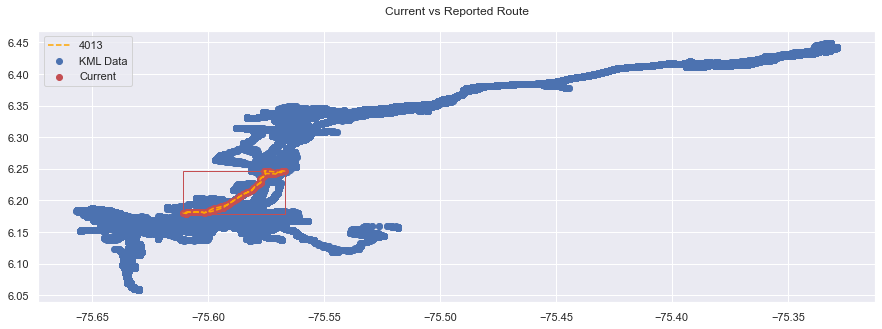

In [ ]:
plot_compare(RUTAS, current, True)

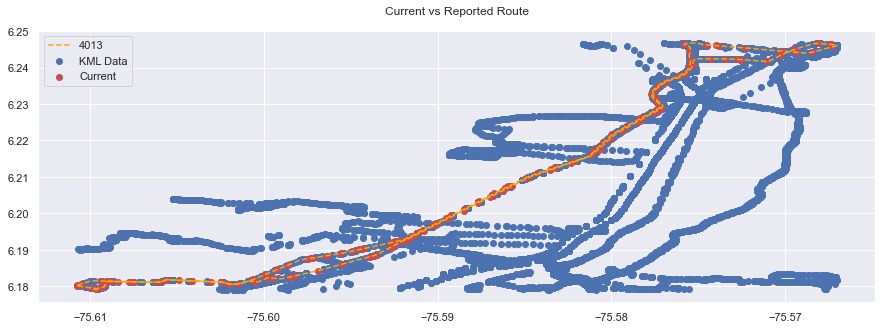

In [ ]:
plot_compare(
    RUTAS[long_cond_r & lat_cond_r], 
    current[long_cond_c & lat_cond_c],
    False
)

In [ ]:
def predict_CODIGORUTA(long, lat):
    """
    Filter RUTAS with MinMax LongLat from current route, 
    then predict probability using KNN 
    and return CODIGORUTA with highest probability sum.
    
    input:
        long: list
        lat:  list
    output:
        prediction: int
    """
    try:
        long_cond = (RUTAS['LONGITUD'] > min(long)) & (RUTAS['LONGITUD'] < max(long))
        lat_cond  = (RUTAS['LATITUD']  > min(lat))  & (RUTAS['LATITUD']  < max(lat))
        RUTAS_filtered = RUTAS[long_cond & lat_cond]#[['LONGITUD', 'LATITUD', 'CODIGORUTA']]

        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(RUTAS_filtered[['LONGITUD', 'LATITUD']], 
                RUTAS_filtered['CODIGORUTA'])

        pred_prob = knn.predict_proba(list(zip(long, lat)))
        prediction = sorted(zip(pred_prob.sum(axis=0), knn.classes_), 
                            reverse=True)[0][1]
    except:
        prediction = 'ERROR'
    
    return prediction

## Predict

In [ ]:
%%time
predicted_route =\
BUS[['LONGITUD', 'LATITUD', 'CODIGORUTA', 'SECUENCIARECORRIDO']]\
   .groupby(['SECUENCIARECORRIDO', 'CODIGORUTA'])\
   .agg(list).apply(lambda c: predict_CODIGORUTA(c['LONGITUD'], c['LATITUD']), 
                    axis=1)

Wall time: 2min 13s


In [ ]:
seq_route = BUS.groupby(['SECUENCIARECORRIDO', 'CODIGORUTA']).agg(lambda g: 0)
cm = pd.crosstab(seq_route.index.get_level_values('CODIGORUTA'), 
                 predicted_route)

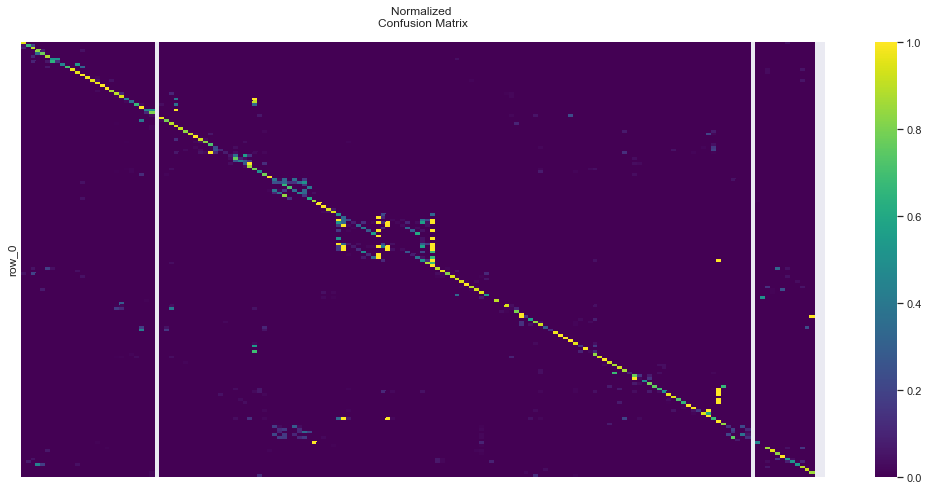

In [ ]:
plt.figure(figsize=(18, 8))
sns.heatmap(
    cm/cm.sum(axis=1),
    cmap='viridis',
    vmin=0,
    vmax=1,
    xticklabels=False,
    yticklabels=False
)
plt.title('Normalized \nConfusion Matrix');

if save_figures:
    plt.savefig(rf'{PATH_PLOT}\ConfusionMatrix', 
                dpi=300,
                bbox_inches='tight')

In [ ]:
count = 0
codes = sorted(RUTAS['CODIGORUTA'].unique())

print('reported != predicted:')
for cod in codes:
    try:
        compare = (cod == cm.index[cm[cod].argmax()])
        if  compare:
            count += 1
        else:
            print('\t', cod, cm.index[cm[cod].argmax()])
    except:
        print('\t', cod, 'ERROR')

result = f'{count/len(codes):.2%}'
f'RESULT: {result}'

reported != predicted:
	 2008 2009
	 2009 2008
	 4016 ERROR
	 4025 4013
	 5306 5407
	 5401 5403
	 5507 5501
	 5509 5507
	 5901 4004
	 7102 7202
	 7103 7203
	 7201 7101
	 7203 7102
	 7305 73050
	 9102 9104
	 9103 9106
	 9107 9207
	 9201 9108
	 9202 9205
	 9203 9206
	 9205 9105
	 9206 9104
	 9207 9107
	 9208 9108
	 9209 9109
	 9313 9105
	 9315 9104
	 20120 200600
	 41030 41160
	 41150 49170
	 42080 42130
	 49110 5901
	 52010 52020
	 52020 52010
	 54200 54180
	 59260 54130
	 71010 72010
	 71020 72020
	 71040 72040
	 72040 ERROR
	 74130 20120
	 4004000 42130
	 4005000 ERROR


'RESULT: 73.46%'

## Execution time

In [ ]:
endTIME = time()
print('Execution time: ', strftime("%Hh%Mm%Ss", gmtime(endTIME - startTIME)))

Execution time:  00h02m39s


## Conclusions

* Reported vs Predicted: {{result}}
* Posible explanations:
    - Misreporting
    - Model quality
    - Errors in KML
* Reasonable Execution time: {{strftime("%Hh%Mm%Ss", gmtime(endTIME - startTIME))}}
<br><br>
* __Concerns:__
    - KNN favors dense KML files
    - Missing KML files
    - Model performs better at completed routes